# HRP Allocation system on very liquid YFinance ticker : 

In [554]:
# Library Importation : 
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
from matplotlib import style
import yfinance as yf
import warnings
import riskfolio as rp 
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
import itertools

In [556]:
# Date range 
start = '2013-01-01'
end = '2024-03-11'

Assets = ["AAPL","MSFT","GOOGL","META","AMZN","TSLA","ASML","NVDA","UNH","V",'TSM','AVGO','NFLX','NSRGF',"AZNCF","PEP","SNYNF","SONY","UBS","SAFRY"]

In [558]:
data = yf.download(Assets, start = start, end = end)['Adj Close']

[*********************100%%**********************]  20 of 20 completed


In [560]:
# Returns : 
Y = data[Assets].pct_change().dropna()

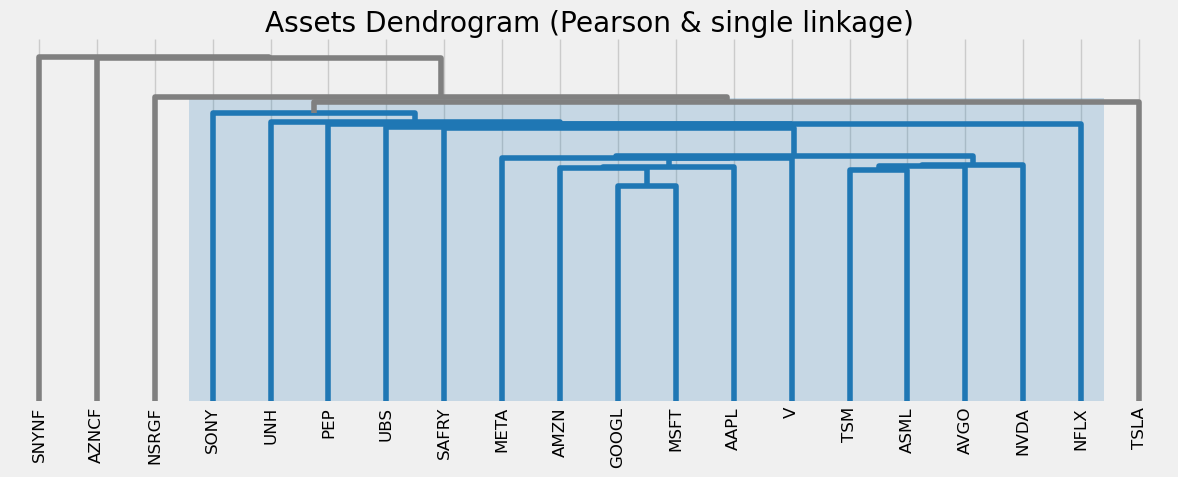

In [562]:
ax = rp.plot_dendrogram(returns=Y,
                       codependence = 'pearson',
                       linkage = 'single',
                       k = None,
                       max_k = 20,
                       leaf_order=True,
                       ax = None)

In [564]:
port = rp.HCPortfolio(returns = Y)

In [566]:
model = 'HRP'
codependence = 'peasron'
rm = 'MV'
rf = 0
linkage = 'single'
max_k = 20
leaf_order = True

In [568]:
# Portfolio Optimization: 
w = port.optimization(model = model,
                      rm = rm,
                      rf = rf,
                      linkage = linkage,
                      max_k = max_k,
                      leaf_order = leaf_order)

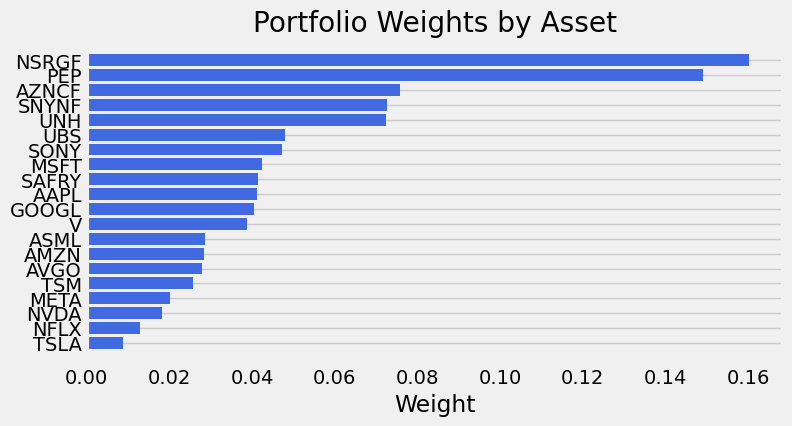

In [570]:
# Let's have a look on the weights founds for each Ticker: 

first_column_name = w.columns[0]
sorted_indices = w.sort_values(by=first_column_name,ascending=False).index
sorted_weights = w.sort_values(by=first_column_name,ascending=False).values

asset_mapping = {asset_name: idx for idx, asset_name in enumerate(Assets)}

sorted_positions = [asset_mapping[i] for i in sorted_indices]
sorted_assets = [Assets[pos] for pos in sorted_positions]

fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_assets, sorted_weights[:,0],color = 'royalblue')
ax.set_xlabel("Weight")
ax.set_title('Portfolio Weights by Asset')
ax.invert_yaxis()
ax.grid(axis = 'x')

# Let's now optimize the HRP allocation mecanism throw various parameter : 
## - Few codependence metrics
## - Few Risk measure values
## - Few Linkage methods

In [573]:
# Initialize the pramaters grid as a Dict :
param_grid = {
    "model" : ['HRP'],
    "codependence" : ['pearson','spearman','abs_pearson','abs_spearman'],
    'rm' : ['MV','MAD','MSV'],
    'linkage' : ['single','complete','average','ward'],
    'max_k' : [20],
    'leaf_order' : [True,False]
}

all_combinations = list(itertools.product(*param_grid.values()))

In [575]:
results = {}

In [577]:
# Lets now define function to have a look on the behavior of the obtained allocation strategy: 

# Statistics for each portfolios : 
# Input_Type : Float_list,DataFrame
# Output_Type : Array (float,float,float)

def get_ret_vol_sr(weights,portefeuille):
        weights = np.array(weights) # Array
        init_return = (weights * portefeuille).sum(axis=1)
        ret = init_return.sum() * 252/len(portefeuille)
        vol = init_return.std() * 252/len(portefeuille)**0.5
        sr = ret/vol
        return np.array([ret,vol,sr]) # Array

# About the allocation mecanism :
## The Historical portfolio timeseries are cut into periods as follow:
## At each Re-Allocation date (every 21 business day) we want to have an optmimized HRP allocation based on the last 63 daily Close.  

In [580]:
# Lets cut the timeseris into portfolios: 
debut = 0 
fin = 63
window_lenght = 21

portefeuille_pour_backtest_liste = []
portefeuille_pour_investir_liste = []

for k in range(int(len(data)/window_lenght)-3):
    
    portefeuille_pour_backtest = data[debut:fin]
    portefeuille_pour_investir = data[fin-1:fin + window_lenght-1]
    
    portefeuille_pour_backtest_liste.append(portefeuille_pour_backtest.pct_change().dropna())
    portefeuille_pour_investir_liste.append(portefeuille_pour_investir.pct_change().dropna())

    debut = debut + window_lenght
    fin = fin + window_lenght

In [582]:
# We can now for each portfolio, find the optimized HRP Allocation setup: 

weights_list = []
best_params_liste = []
Realized_results = []
best_key_liste = []

for train,test in zip (portefeuille_pour_backtest_liste,portefeuille_pour_investir_liste):
    
    results = {}
    Y = train

    for combo in all_combinations:
        
        params = dict(zip(param_grid.keys(),combo))
        port = rp.HCPortfolio(returns=Y)
        
        # Portfolio Optimization: 
        w = port.optimization(model = params['model'],
                              codependence = params['codependence'],
                              rm = params['rm'],
                              rf =0,
                              linkage = params['linkage'],
                              max_k = params['max_k'],
                              leaf_order = params['leaf_order'])
        
        # Check if weights are valid
        if w.isnull().any().any() or not np.isclose(w['weights'].sum(), 1, atol = 0.0001):
            print("Invalid weighrs detected, skippingd...")
            continue
            
        # Backtesting 
        returns,vol,sharpe_ratio = get_ret_vol_sr(w['weights'],Y)
        key = (combo)
        results[key] = {'Return' : returns, 'Volatility' : vol,'Sharpe Ratio' : sharpe_ratio,'weights' : w["weights"]}
        
    best_key = max(results, key = lambda x: results[x]['Sharpe Ratio'])
    best_params = results[best_key]
    best_key_liste.append(best_key)
    best_params_liste.append(best_params)
    
    # testing 
    returns_test,vol_test,sharpe_ratio_test = get_ret_vol_sr(best_params['weights'],test)
    Realized_results.append([returns_test,vol_test,sharpe_ratio_test])

In [583]:
final_results = pd.DataFrame(Realized_results)
final_results.columns = ["Returns","Vol","Sharpe Ratio"]

# Comparatif des ratio de sharpe train/test:

train_sharpe_liste = []
train_weights_liste = []
for value in best_params_liste:
    train_sharpe_liste.append(value["Sharpe Ratio"])
    train_weights_liste.append(value["weights"])
    
train_sharpe_liste = pd.DataFrame(train_sharpe_liste)
train_sharpe_liste.rename(columns  = {0 : "Train Sharpe Ratio"},inplace = True)
train_sharpe_liste["Realized sharpe ratio"] = final_results["Sharpe Ratio"]

In [584]:
# The Sharpe ratio obtained on the Train Vs Test DataFrame:
train_sharpe_liste.mean()

Train Sharpe Ratio       1.302865
Realized sharpe ratio    0.673015
dtype: float64

In [585]:
# % Amount of the realized SR Vs the Trained One:
train_sharpe_liste.mean()["Realized sharpe ratio"]/train_sharpe_liste.mean()["Train Sharpe Ratio"]

0.5165655536027124

In [586]:
# Now that we have the weights for each re allocation time, let's get the equity curve : 
equity_liste = []
equity_liste_equal_weight = []
Amount = []
Amount_equal_weight = []
original_equity_liste = []
Amount_equal_weight.append(1)
Amount.append(1)

for weights,frame in zip(train_weights_liste,portefeuille_pour_investir_liste[:-1]):
    
    equal_weights = []
    for k in range(len(frame.columns)):
        equal_weights.append(1/len(frame.columns))
    
    weights_equal_weights = weights.replace(weights.values,equal_weights)
    
    share_value = data.loc[frame.index[0]]
    
    amount_of_money = Amount[-1] * weights
    amount_of_money_equal_weight = Amount_equal_weight[-1] * weights_equal_weights
    
    amount_of_share = np.round(amount_of_money/share_value,5)
    amount_of_share_equal_weight = np.round(amount_of_money_equal_weight/share_value,5)

    initial_equity_curve = amount_of_share * share_value
    initial_equity_curve_equal_weight = amount_of_share_equal_weight * share_value
    
    equity_frame = initial_equity_curve * (1+frame[1:]).cumprod()
    equity_frame_equal_weight = initial_equity_curve_equal_weight * (1+frame[1:]).cumprod()
        
    equity_liste.append(equity_frame.sum(axis=1))
    original_equity_liste.append(equity_frame)
    equity_liste_equal_weight.append(equity_frame_equal_weight.sum(axis=1))

    Amount.append(equity_frame.sum(axis=1)[-1])
    Amount_equal_weight.append(equity_frame_equal_weight.sum(axis=1)[-1])

Text(0.5, 1.0, 'Equity Curve of the HRP and Equaly weighted Allocations')

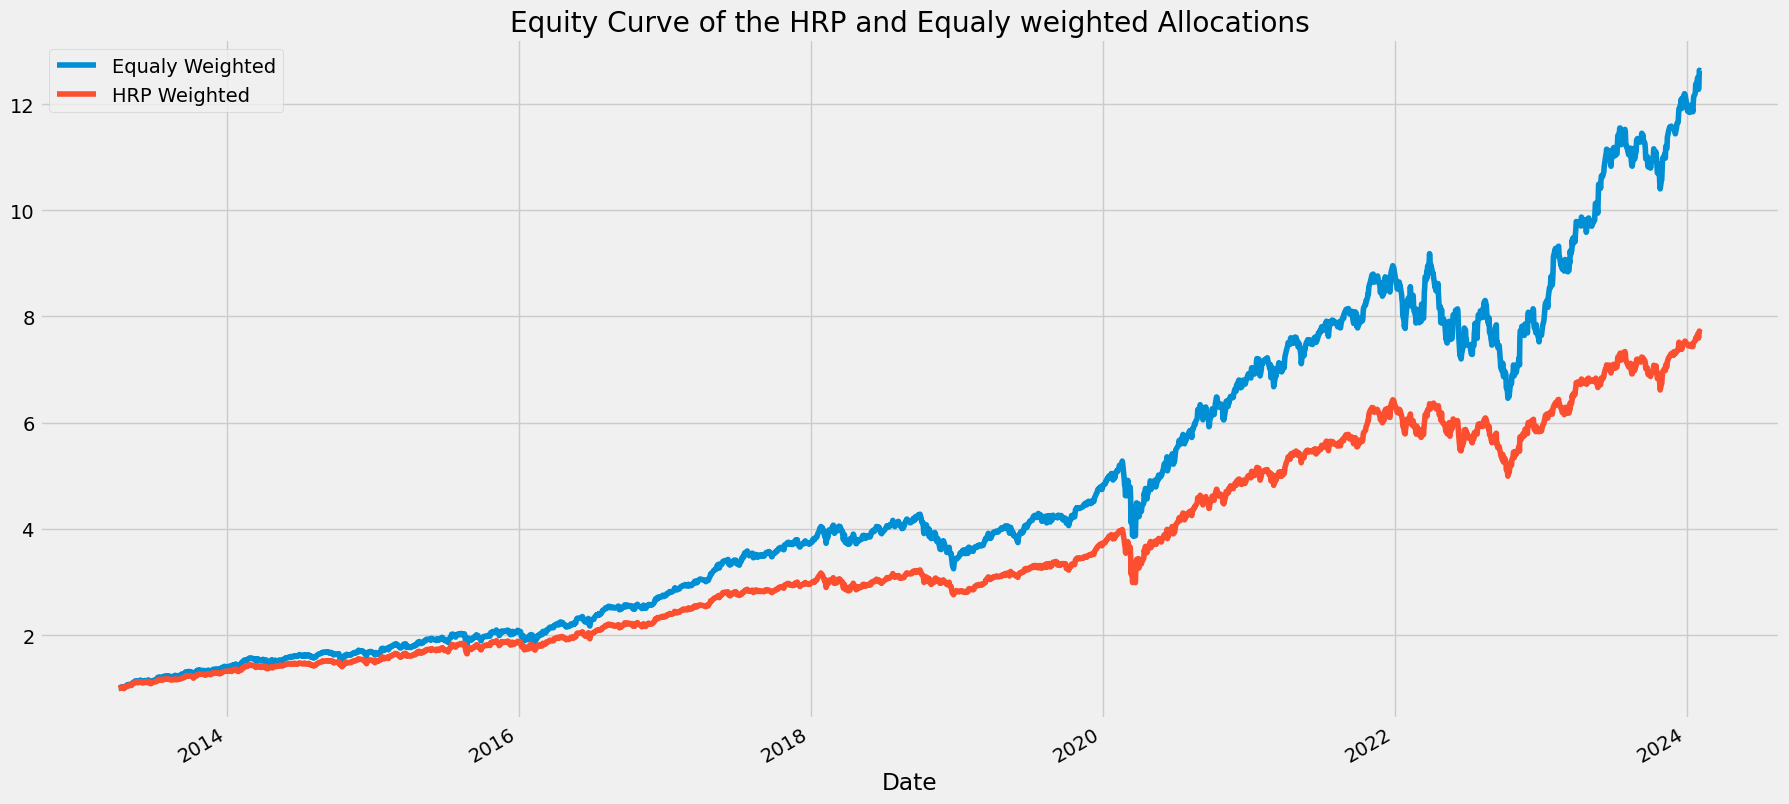

In [587]:
pd.concat(equity_liste_equal_weight).plot(label = "Equaly Weighted",figsize = (20,10))
pd.concat(equity_liste).plot(label = "HRP Weighted")
plt.legend()
plt.title("Equity Curve of the HRP and Equaly weighted Allocations")

In [588]:
# Input : time_series_Dataframe
# Output : Float (%)
def get_return(equity_curve):
    # % Return
    return (equity_curve.iloc[-1]/equity_curve.iloc[0] - 1) * 100 

In [589]:
def get_time_to_recovery(drawdown_curve):
    
    liste = [] 
    nombre = 0 
    
    drawdown_curve["compteur"] = drawdown_curve[drawdown_curve.columns[0]]
    
    for k in range (len(drawdown_curve)):
        
        if drawdown_curve[drawdown_curve.columns[0]][k]*100<=-1.5:
            drawdown_curve["compteur"][k] = 1
            
        else : 
             drawdown_curve["compteur"][k] = 0
            
    for k in range (len(drawdown_curve["compteur"])-1):
        
        if drawdown_curve["compteur"][k] == 1 and drawdown_curve["compteur"][k+1] == 1:
            nombre+=1
            
        if drawdown_curve["compteur"][k] == 1 and drawdown_curve["compteur"][k+1] == 0:
            nombre = 0
            
        liste.append(nombre)
        
    liste = pd.DataFrame(liste)
    drawdown_curve.drop(columns = "compteur",inplace = True)
    
    return round(liste.max()/252,2)

In [590]:
# Drawdown : 
# Input_Type : Float_List
# Output_Type : Float_List
def DD(Equity):
    previous_peaks = Equity.cummax()
    drawdown = (Equity-previous_peaks) / previous_peaks
    return drawdown 

# Max_Drawdown : 
# Input_Type : Float_List
# Output_Type : Float
def Max_DD(equity):
    return round(DD(equity).min()*100)

# Annualized Return : 
# Input_Type : Float,Float
# Output_Type : Float    
def Get_Annualized_Return(Return,duration):
    return round((round(Return,2)**(1/duration)-1)*100,2)  

In [591]:
# Statistics of the strategy : 
# Return % : 
return_equal_weights = np.round(get_return(pd.concat(equity_liste_equal_weight)),2)
return_strategy = np.round(get_return(pd.concat(equity_liste)),2)
# Drawdown curve : 
drawdown_equal_weights = DD(pd.concat(equity_liste_equal_weight))
drawdown_strategy = DD(pd.concat(equity_liste))
drawdown_equal_weights = pd.DataFrame(drawdown_equal_weights)
drawdown_strategy = pd.DataFrame(drawdown_strategy)
# Max Drawdown % :
Max_drawdown_equal_weights = Max_DD(pd.concat(equity_liste_equal_weight))
Max_drawdown_strategy = Max_DD(pd.concat(equity_liste))
# Time to recover in year : 
time_to_recover_equal_weights = get_time_to_recovery(drawdown_equal_weights)
time_to_recover_strategy = get_time_to_recovery(drawdown_strategy)

In [592]:
# Statistics Summary : 
Stats_frame = pd.DataFrame([return_equal_weights,return_strategy])
Stats_frame.index = ["Equal Weights","HRP Strategy"]
Stats_frame.rename(columns = {0:"% Return"},inplace = True)
Stats_frame["Max Drawdown"] = [Max_drawdown_equal_weights,Max_drawdown_strategy]
Stats_frame["Time to recover in year"] = [time_to_recover_equal_weights[0],time_to_recover_strategy[0]]
Stats_frame

,% Return,Max Drawdown,Time to recover in year
Equal Weights,1167.92,-30,0.75
HRP Strategy,673.55,-25,0.74
